In [1]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 시스템에 설치된 폰트 목록 출력
for font in fm.findSystemFonts(fontpaths=None, fontext='ttf'):
    print(fm.FontProperties(fname=font).get_name(), font)

Segoe UI C:\Windows\Fonts\seguisbi.ttf
Yu Gothic C:\Windows\Fonts\YuGothM.ttc
Gill Sans MT C:\Windows\Fonts\GILB____.TTF
High Tower Text C:\Windows\Fonts\HTOWERT.TTF
Myanmar Text C:\Windows\Fonts\mmrtextb.ttf
Yu Gothic C:\Windows\Fonts\YuGothL.ttc
Nirmala UI C:\Windows\Fonts\NirmalaB.ttf
Bodoni MT C:\Windows\Fonts\BOD_R.TTF
Franklin Gothic Demi C:\Windows\Fonts\FRADM.TTF
Gill Sans MT Ext Condensed Bold C:\Windows\Fonts\GLSNECB.TTF
Corbel C:\Windows\Fonts\corbell.ttf
Myanmar Text C:\Windows\Fonts\mmrtext.ttf
Consolas C:\Windows\Fonts\consolaz.ttf
Constantia C:\Windows\Fonts\constanb.ttf
Consolas C:\Windows\Fonts\consola.ttf
Segoe UI Emoji C:\Windows\Fonts\seguiemj.ttf
Segoe UI C:\Windows\Fonts\seguili.ttf
Goudy Old Style C:\Windows\Fonts\GOUDOS.TTF
Book Antiqua C:\Windows\Fonts\ANTQUAI.TTF
Impact C:\Windows\Fonts\impact.ttf
Lucida Fax C:\Windows\Fonts\LFAXI.TTF
Bodoni MT C:\Windows\Fonts\BOD_CI.TTF
Leelawadee UI C:\Windows\Fonts\LeelawUI.ttf
Berlin Sans FB C:\Windows\Fonts\BRLNSR.TTF
HY

In [2]:
import pandas as pd
import numpy as np

# !pip install pykrx
from pykrx import stock

from tqdm import tqdm
import time

import seaborn as sns

In [3]:
df = pd.read_csv("./meta_data.csv")
df

,종목코드,종목명,시장구분,업종명,종가,대비,등락률,시가총액
0,120110,코오롱인더,KOSPI,화학,36550,-50,-0.14,1005822776050
1,150,두산,KOSPI,기타금융,137000,4100,3.09,2263765395000
2,24720,콜마홀딩스,KOSPI,기타금융,8250,20,0.24,303348540000
3,24720,콜마홀딩스,KOSPI,기타금융,8250,20,0.24,303348540000
4,4560,현대비앤지스틸,KOSPI,철강금속,20950,600,2.95,315901090450
...,...,...,...,...,...,...,...,...
141,4990,롯데지주,KOSPI,기타금융,26500,-300,-1.12,2780094780500
142,267260,HD현대일렉트릭,KOSPI,전기전자,255000,15000,6.25,9192019425000
143,1740,SK네트웍스,KOSPI,유통업,5540,-20,-0.36,1225879577080
144,5930,삼성전자,KOSPI,전기전자,78600,3100,4.11,469224908430000


In [4]:
df['종목코드'] = df['종목코드'].astype(str).str.zfill(6)

In [5]:
import numpy as np 
from statsmodels import regression
import statsmodels.api as sm 
import matplotlib.pyplot as plt 
import math
import pandas as pd 
import pandas_datareader as pdr 

In [6]:
sector_counts = df.groupby('업종명').size().reset_index(name='종목수')

print(sector_counts)

      업종명  종목수
0     건설업    6
1      기계    3
2    기타금융   20
3      보험    4
4   비금속광물    4
5    서비스업   11
6    섬유의복    1
7    운수장비   10
8   운수창고업    6
9     유통업   13
10     은행    2
11   음식료품    3
12    의약품    7
13  전기가스업    3
14   전기전자   13
15   종이목재    2
16     증권    5
17   철강금속    7
18    통신업    2
19     화학   24


In [7]:
import FinanceDataReader as fdr
import pandas as pd
import numpy as np
import networkx as nx
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import seaborn as sns
import networkx as nx

In [8]:
def create_graph_with_correlation(df, start, end):
    G = nx.Graph()
    
    # 모든 주식의 종가 데이터 가져오기
    stock_prices = {}
    for idx, row in tqdm(df.iterrows(), total=df.shape[0]):
        code = row["종목코드"]
        name = row["종목명"]
        sector = row["업종명"]
        try:
            asset = fdr.DataReader(code, start, end)
            stock_prices[code] = asset['Close']
        except:
            print(f"No data for {code} ({name})")
            continue
    
    # 가장 긴 공통 기간 찾기
    min_date = max([prices.index.min() for prices in stock_prices.values() if not prices.empty])
    max_date = min([prices.index.max() for prices in stock_prices.values() if not prices.empty])
    
    # 유효한 기간이 없는 경우 처리
    if pd.isna(min_date) or pd.isna(max_date):
        raise ValueError("No common dates available in the dataset.")
    
    # 공통 기간 내의 데이터를 기준으로 필터링
    common_dates = pd.date_range(start=min_date, end=max_date)
    print(f"Common date range: {min_date} to {max_date}")

    filtered_prices = {}
    for code in stock_prices:
        filtered_prices[code] = stock_prices[code].reindex(common_dates).dropna()
    
    # 시가총액 상위 50개 종목 선택
    valid_codes = [code for code in filtered_prices if len(filtered_prices[code]) > 0]
    top_50_df = df[df['종목코드'].isin(valid_codes)].nlargest(50, '시가총액')

    print(f"Valid codes after filtering: {len(valid_codes)}")
    print(f"Top 50 codes selected: {len(top_50_df)}")

    # 시가총액 상위 50개 종목에 대해 다시 종가 데이터를 가져오기
    stock_prices_top_50 = {code: filtered_prices[code] for code in top_50_df['종목코드']}

    for idx, row in tqdm(top_50_df.iterrows(), total=top_50_df.shape[0]):
        code = row["종목코드"]
        name = row["종목명"]
        sector = row["업종명"]
        
        # 그래프 노드에 종목명과 업종명 추가
        G.add_node(name, sector=sector)
    
    codes = list(stock_prices_top_50.keys())
    edge_count = 0
    for i in range(len(codes)):
        for j in range(i + 1, len(codes)):
            code_i = codes[i]
            code_j = codes[j]
            
            # 두 종목의 종가 데이터 가져오기
            prices_i = stock_prices_top_50[code_i]
            prices_j = stock_prices_top_50[code_j]
            
            # 상관 관계 계산
            if len(prices_i) > 1 and len(prices_j) > 1:  # 최소한 두 개의 데이터 포인트가 있는 경우
                correlation = prices_i.corr(prices_j)
                if not np.isnan(correlation) and correlation > 0.5:  # 상관 관계가 높은 경우만 엣지 추가
                    G.add_edge(df.loc[df['종목코드'] == code_i, '종목명'].values[0], 
                               df.loc[df['종목코드'] == code_j, '종목명'].values[0], 
                               weight=correlation)
                    edge_count += 1
    
    print(f"Total edges added: {edge_count}")

    # 연결된 엣지가 없는 노드 제거
    nodes_to_remove = [node for node in G.nodes if G.degree(node) == 0]
    G.remove_nodes_from(nodes_to_remove)
    print(f"Nodes removed due to no edges: {len(nodes_to_remove)}")

    return G

In [9]:
start_date = '2020-01-01'
end_date = '2020-02-28'

G = create_graph_with_correlation(df, start_date, end_date)

num_nodes = G.number_of_nodes()

print(f"Number of nodes in the graph: {num_nodes}")


100%|██████████| 146/146 [01:20<00:00,  1.82it/s]


Common date range: 2020-01-02 00:00:00 to 2020-02-28 00:00:00
Valid codes after filtering: 129
Top 50 codes selected: 50


100%|██████████| 50/50 [00:00<00:00, 14486.10it/s]


Total edges added: 449
Nodes removed due to no edges: 0
Number of nodes in the graph: 45


In [10]:
print("Edge weights:")
for (u, v, weight) in G.edges(data=True):
    print(f"({u}, {v}): {weight['weight']}")

Edge weights:
(삼성전자, 포스코퓨처엠): 0.5035774510715382
(삼성전자, LG): 0.6668872262813549
(삼성전자, 삼성에스디에스): 0.7735295324986219
(삼성전자, 삼성전기): 0.6265731086517583
(삼성전자, HD현대일렉트릭): 0.5272571326529227
(삼성전자, 현대글로비스): 0.5601535794312106
(삼성전자, LG생활건강): 0.7798704049829914
(삼성전자, LG이노텍): 0.6518673823691895
(삼성전자, 넷마블): 0.7524156633424569
(삼성전자, 현대로템): 0.6303852701577727
(삼성전자, 롯데케미칼): 0.5017987415881674
(삼성전자, 한미약품): 0.5454772865891958
(삼성바이오로직스, LG화학): 0.8365807832784719
(삼성바이오로직스, 포스코퓨처엠): 0.9108636298587258
(삼성바이오로직스, LG): 0.575747341835441
(삼성바이오로직스, 삼성전기): 0.5487714545787431
(삼성바이오로직스, LG이노텍): 0.5676990325379667
(삼성바이오로직스, SKC): 0.8279427102669804
(삼성바이오로직스, LG유플러스): 0.5271247571978472
(기아, 현대모비스): 0.8604665648022733
(기아, 신한지주): 0.742392727249622
(기아, 삼성생명): 0.8100500129706075
(기아, 하나금융지주): 0.73142002155777
(기아, LG전자): 0.8527187534218424
(기아, 한화에어로스페이스): 0.8391922638088012
(기아, SK): 0.7690324064386889
(기아, 삼성에스디에스): 0.827084590307086
(기아, SK텔레콤): 0.8112881478284977
(기아, 기업은행): 0.698086383438229
(기아

In [11]:
font_path = "C:/Windows/Fonts/malgun.ttf"  # 폰트 파일 경로
font_prop = fm.FontProperties(fname=font_path)
plt.rc('font', family=font_prop.get_name())

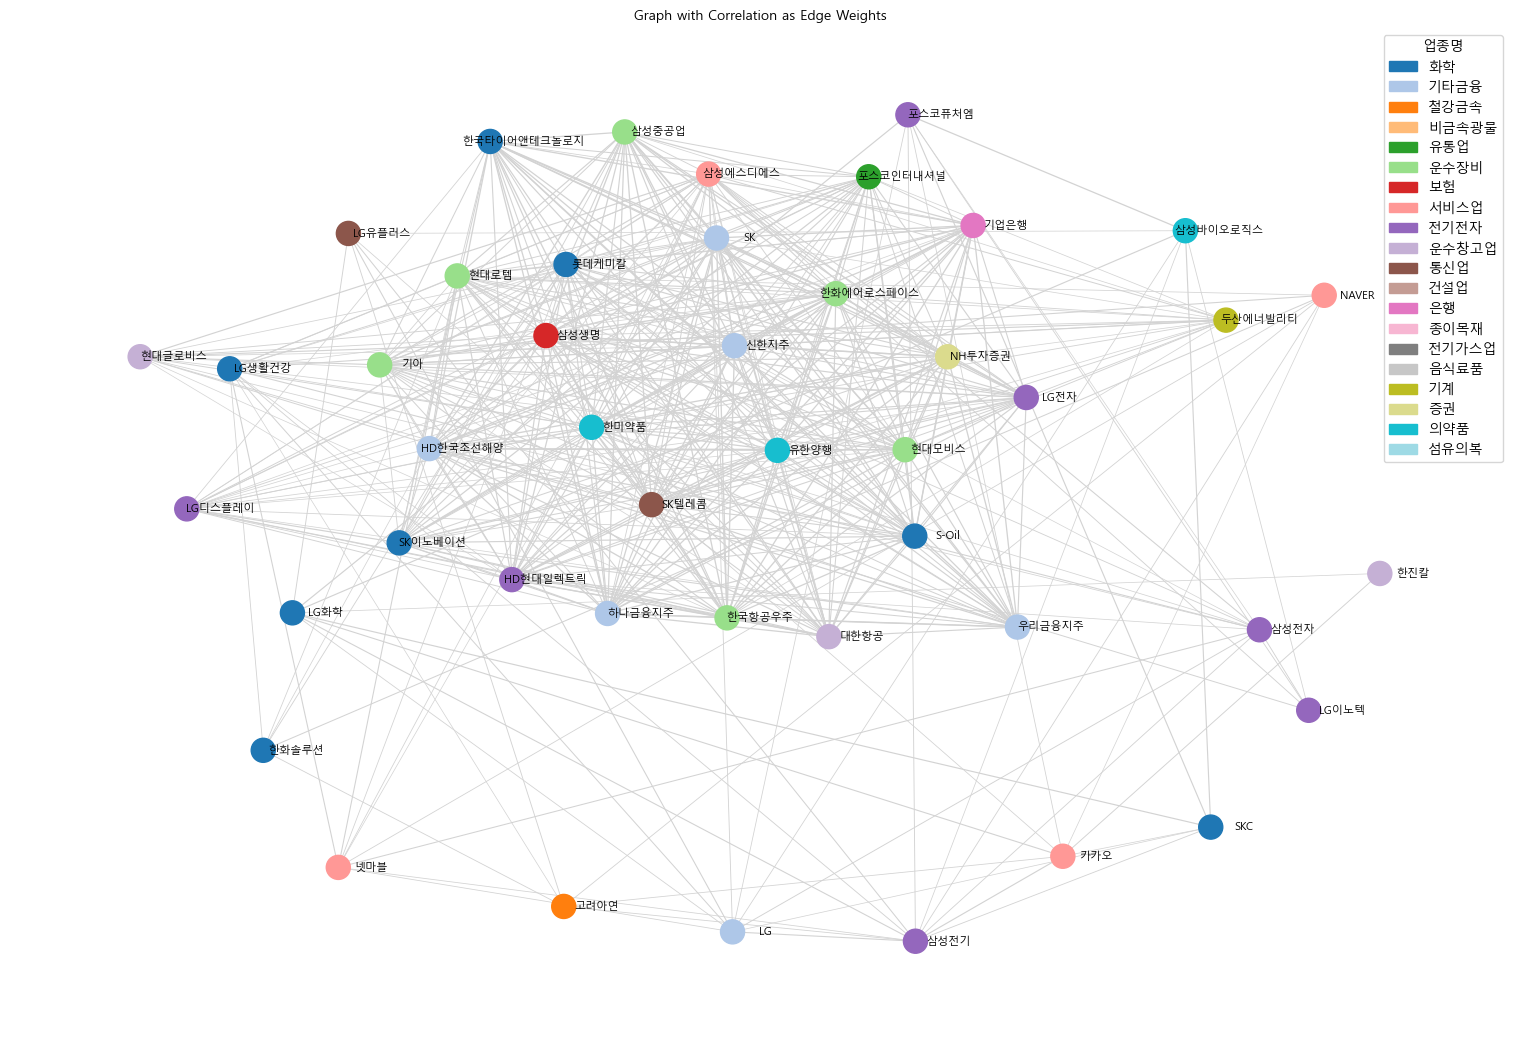

In [12]:
sectors = pd.unique(df["업종명"])
color_map = plt.get_cmap('tab20', len(sectors))
sector_color = {sector: color_map(i) for i, sector in enumerate(sectors)}

node_colors = [sector_color[G.nodes[node]['sector']] for node in G.nodes]

legend_patches = [mpatches.Patch(color=sector_color[sector], label=sector) for sector in sectors]

plt.figure(figsize=(15, 10))
pos = nx.spring_layout(G, k=2)  # k 값을 조정하여 노드 간 거리 조정
weights = nx.get_edge_attributes(G, 'weight').values()

# 라벨 위치 조정
labels = {node: node for node in G.nodes}
nx.draw(G, pos, with_labels=False, node_color=node_colors, edge_color='lightgray', width=list(weights))
for p in pos:  # 라벨을 노드 옆에 배치
    pos[p][0] += 0.05
nx.draw_networkx_labels(G, pos, labels, font_family=font_prop.get_name(), font_size=8)

plt.title('Graph with Correlation as Edge Weights', fontproperties=font_prop)
plt.legend(handles=legend_patches, loc='best', title='업종명', prop=font_prop)
plt.show()

# MST

In [13]:
mst = nx.minimum_spanning_tree(G)

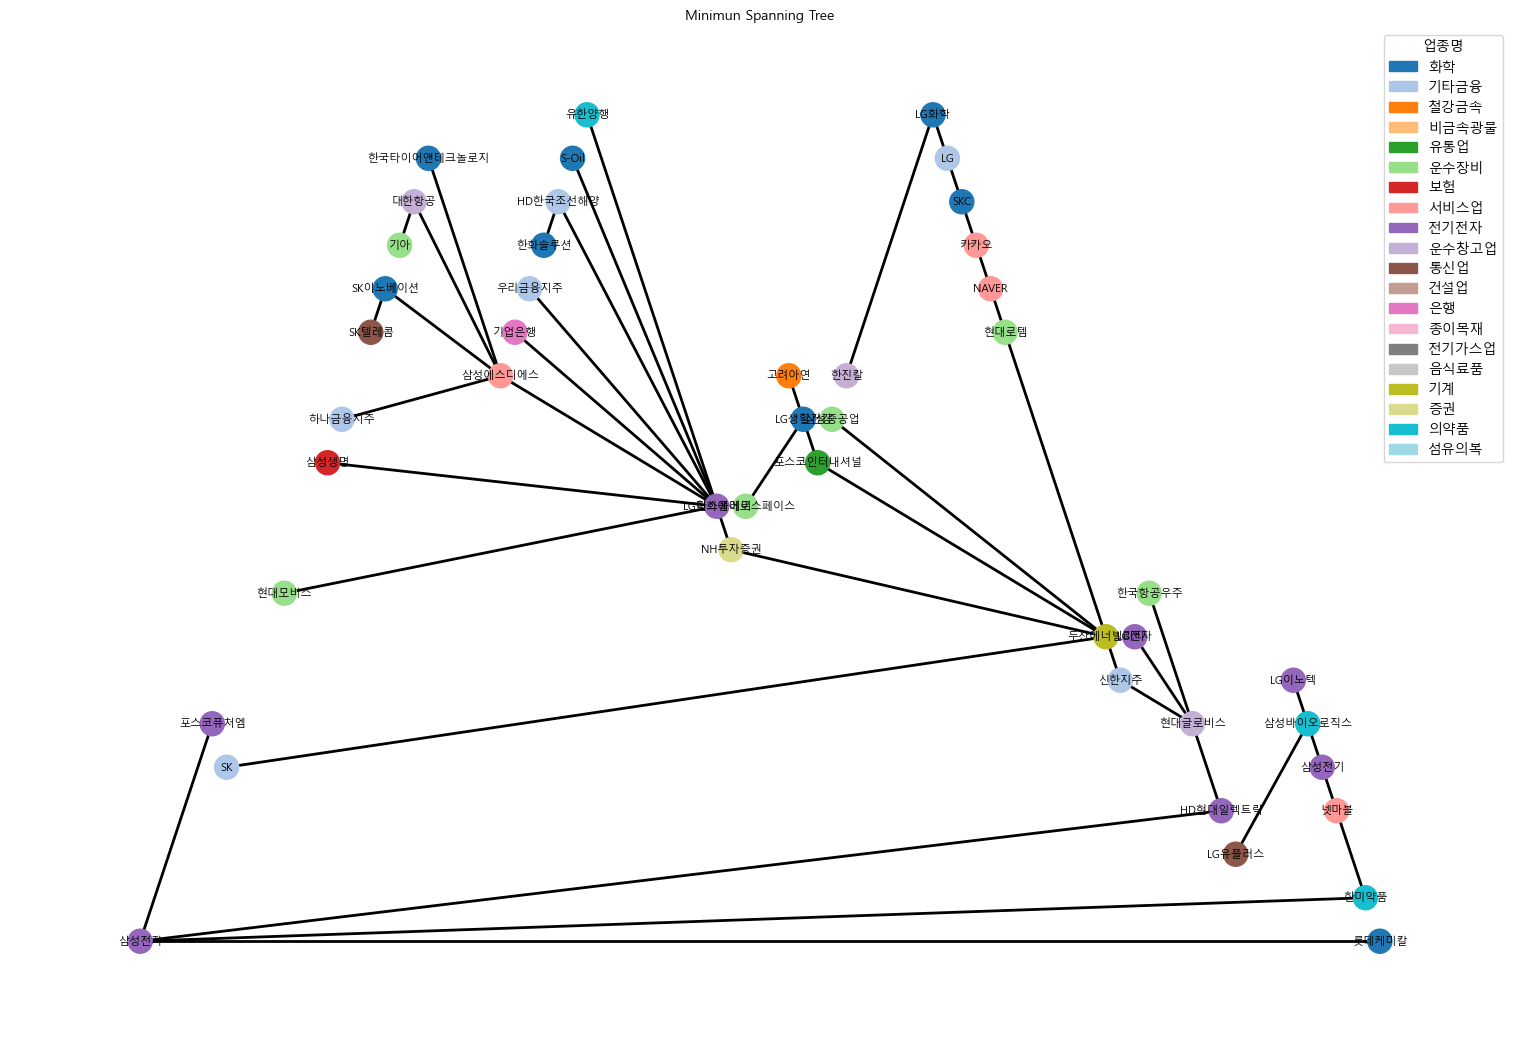

In [14]:
plt.figure(figsize=(15, 10))  
pos = nx.planar_layout(mst)  # 엣지 교차를 줄이기 위해 planar_layout 사용

nx.draw(mst, pos, with_labels=False, node_color=node_colors, edge_color='black', width=2, node_size=300)
nx.draw_networkx_labels(mst, pos, labels={node: node for node in mst.nodes()}, font_family=font_prop.get_name(), font_size=8)
plt.title("Minimun Spanning Tree", fontproperties=font_prop)
plt.legend(handles=legend_patches, loc='best', title='업종명', prop=font_prop)
plt.show()

In [28]:
def analyze_graph(G):
    # 평균 거리 (전체 노드 간 최단 경로의 평균)
    avg_distance = nx.average_shortest_path_length(G)
    
    # 최대 거리 (지름)
    diameter = nx.diameter(G)
    
    # Branch count
    branch_count = sum(1 for node in G.nodes if G.degree(node) > 2)
    
    # 분석 결과 반환
    return {
        # "Average Distance": avg_distance,
        # "Diameter": diameter,
        "Branch Count": branch_count
    }

In [29]:
mst_analysis = analyze_graph(mst)

for key, value in mst_analysis.items():
    print(f"{key}: {value}")

Branch Count: 7


# Centrality Analysis

In [17]:
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G)

In [18]:
centrality_df = pd.DataFrame({
    '종목코드': list(G.nodes),
    '업종명': [G.nodes[node]['sector'] for node in G.nodes],
    'Degree Centrality': [degree_centrality[node] for node in G.nodes],
    'Betweenness Centrality': [betweenness_centrality[node] for node in G.nodes],
    'Closeness Centrality': [closeness_centrality[node] for node in G.nodes],
    'Eigenvector Centrality': [eigenvector_centrality[node] for node in G.nodes]
})

In [31]:
for centrality in ['Degree Centrality', 'Betweenness Centrality', 'Closeness Centrality', 'Eigenvector Centrality']:
    print(f"Top 5 {centrality}")
    display(centrality_df[['종목코드', '업종명', centrality]].nlargest(5, centrality))
    print("\n")

Top 5 Degree Centrality


,종목코드,업종명,Degree Centrality
15,삼성에스디에스,서비스업,0.704545
37,현대로템,운수장비,0.704545
42,한미약품,의약품,0.704545
39,롯데케미칼,화학,0.681818
13,한화에어로스페이스,운수장비,0.659091




Top 5 Betweenness Centrality


,종목코드,업종명,Betweenness Centrality
15,삼성에스디에스,서비스업,0.174654
12,LG,기타금융,0.116463
37,현대로템,운수장비,0.098616
31,LG생활건강,화학,0.065267
0,삼성전자,전기전자,0.053367




Top 5 Closeness Centrality


,종목코드,업종명,Closeness Centrality
15,삼성에스디에스,서비스업,0.745763
37,현대로템,운수장비,0.709677
42,한미약품,의약품,0.687500
39,롯데케미칼,화학,0.676923
23,HD현대일렉트릭,전기전자,0.666667




Top 5 Eigenvector Centrality


,종목코드,업종명,Eigenvector Centrality
42,한미약품,의약품,0.199682
13,한화에어로스페이스,운수장비,0.196781
6,현대모비스,운수장비,0.194707
7,신한지주,기타금융,0.194707
9,삼성생명,보험,0.194707


# Influence Maximization

In [20]:
import random

# 독립적 연접 모델을 사용한 영향 평가 함수
def independent_cascade(G, seed_nodes, steps=1000):
    influenced_nodes = set(seed_nodes)
    new_active = set(seed_nodes)
    for _ in range(steps):
        if not new_active:
            break
        next_active = set()
        for node in new_active:
            for neighbor in G.neighbors(node):
                if neighbor not in influenced_nodes and random.random() < G[node][neighbor]['weight']:
                    next_active.add(neighbor)
        influenced_nodes.update(next_active)
        new_active = next_active
    return len(influenced_nodes)

In [21]:
# Greedy Algorithm을 사용한 시드 노드 선택
def greedy_algorithm(G, k, steps=1000):
    seed_nodes = []
    for _ in tqdm(range(k)):
        best_node = None
        max_influence = -1
        for node in tqdm(G.nodes):
            if node not in seed_nodes:
                influence = independent_cascade(G, seed_nodes + [node], steps)
                if influence > max_influence:
                    best_node = node
                    max_influence = influence
        seed_nodes.append(best_node)
    return seed_nodes

In [22]:
# 시드 노드 수 설정
k = 1

# Greedy Algorithm을 사용하여 시드 노드 선택
seed_nodes = greedy_algorithm(G, k)
print(f"Selected seed nodes: {seed_nodes}")

100%|██████████| 1/1 [00:00<00:00, 71.40it/s]

Selected seed nodes: ['삼성바이오로직스']


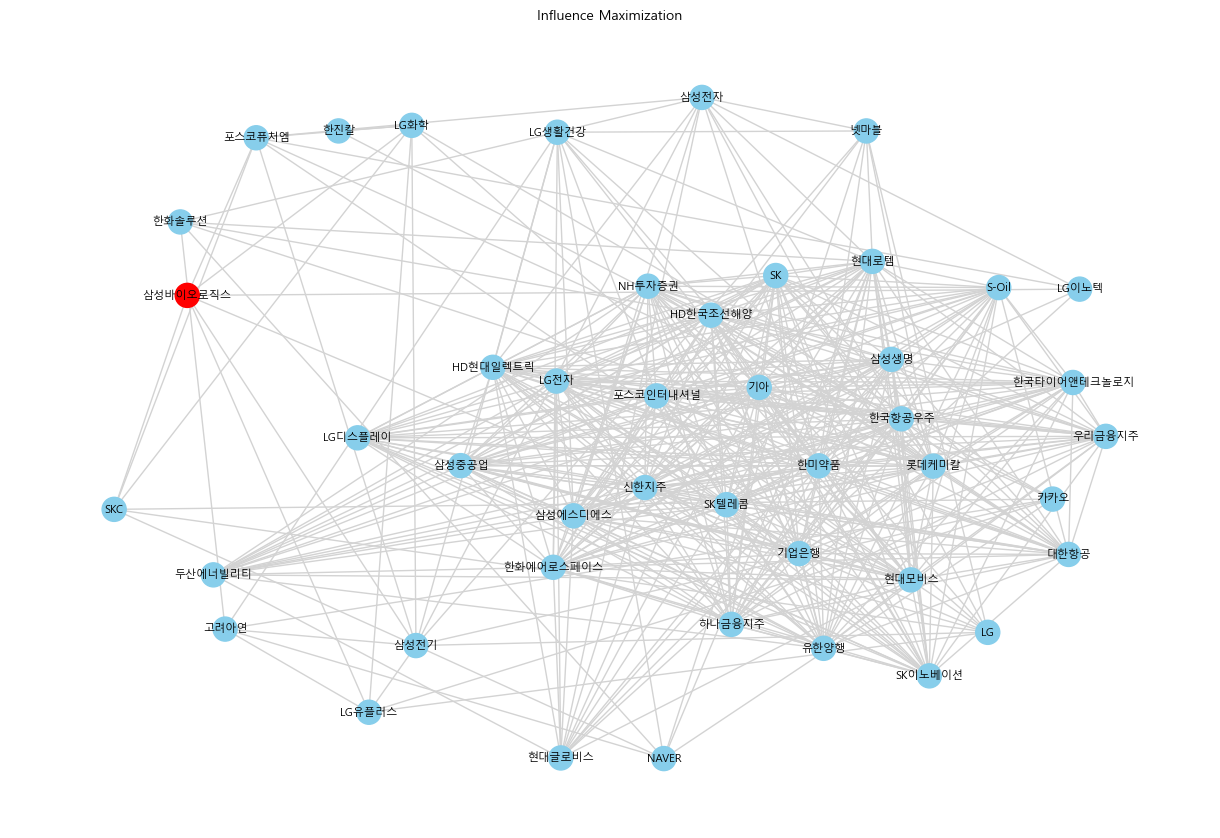

In [23]:
font_path = "C:/Windows/Fonts/malgun.ttf"  # 폰트 파일 경로
font_prop = fm.FontProperties(fname=font_path)
plt.rc('font', family=font_prop.get_name())

# 시각화 (선택된 시드 노드를 강조하여 표시)
pos = nx.spring_layout(G, k=2)

node_colors = ['red' if node in seed_nodes else 'skyblue' for node in G.nodes]

plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color='lightgray', node_size=300, font_size=8, font_family=font_prop.get_name())  # 노드 크기 조정
plt.title("Influence Maximization", fontproperties=font_prop)
plt.show()

# Community Detection

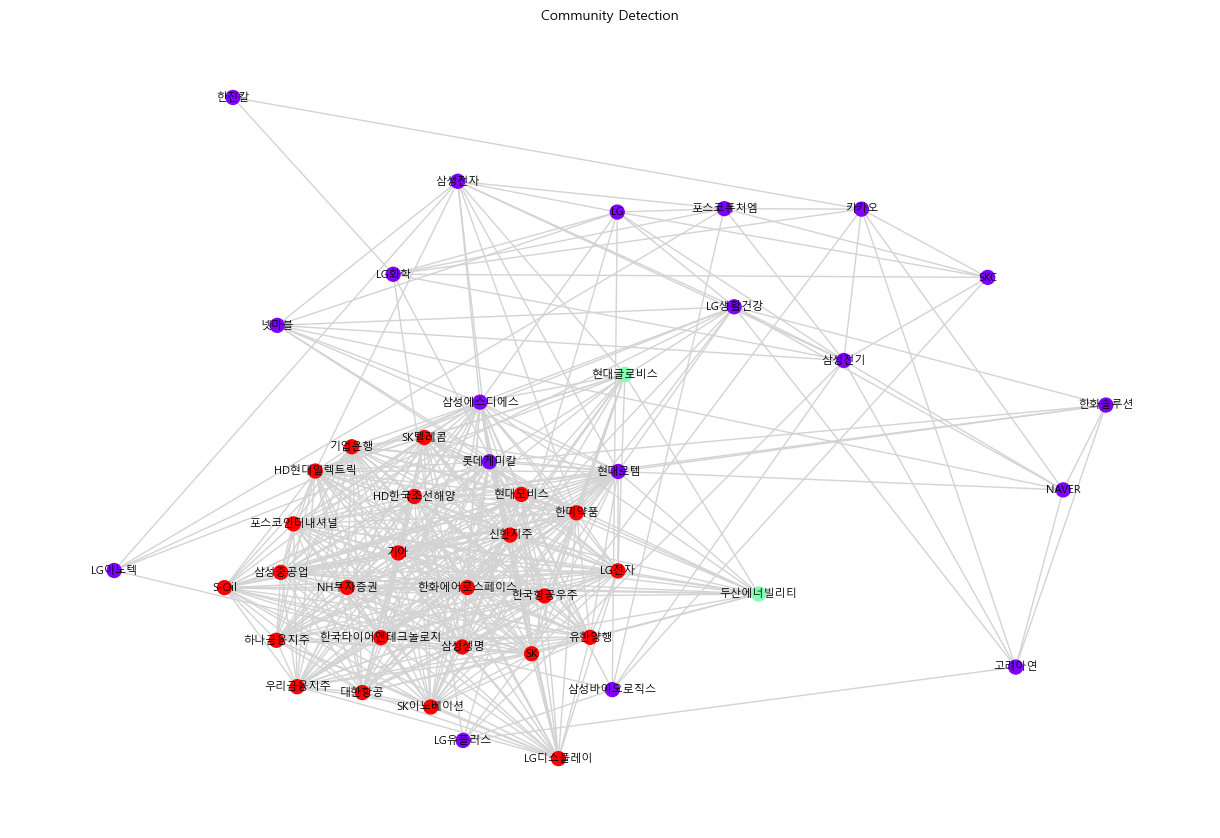

In [32]:
import community as community_louvain

partition = community_louvain.best_partition(G)

# 커뮤니티별로 노드 색상 지정
colors = [partition[node] for node in G.nodes()]

# 한글 폰트 설정
font_path = "C:/Windows/Fonts/malgun.ttf"  # 폰트 파일 경로
font_prop = fm.FontProperties(fname=font_path)
plt.rc('font', family=font_prop.get_name())

# 그래프 시각화
pos = nx.spring_layout(G, k=1)
plt.figure(figsize=(12, 8))

nx.draw(G, pos, node_color=colors, with_labels=True, cmap=plt.cm.rainbow, node_size=100, edge_color='lightgray', font_size=8, font_family=font_prop.get_name())
plt.title("Community Detection", fontproperties=font_prop)

plt.show()

In [25]:
community_df = pd.DataFrame.from_dict(partition, orient='index', columns=['커뮤니티'])
community_df['종목명'] = community_df.index
community_df.reset_index(drop=True, inplace=True)

# 업종명 추가
community_df = community_df.merge(df[['종목명', '업종명']], on='종목명')

# 커뮤니티와 업종명 카운트 피벗 테이블 생성
pivot_table = community_df.pivot_table(index='커뮤니티', columns='업종명', aggfunc='size', fill_value=0)

# 커뮤니티 이름을 "community 1", "community 2" 형식으로 변경
pivot_table.index = [f"community {i+1}" for i in range(len(pivot_table))]

# 결과 출력
pivot_table

업종명,기계,기타금융,보험,서비스업,운수장비,운수창고업,유통업,은행,의약품,전기전자,증권,철강금속,통신업,화학
community 1,1,0,0,1,0,2,0,0,0,2,0,0,0,0
community 2,0,1,0,4,2,1,0,0,1,3,0,1,1,6
community 3,0,5,1,0,5,1,1,1,2,3,1,0,1,3
